# Part I: Applying Image Processing Filters For Image Cartoonifying

In [3]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import requests
import math
import os

Getting image from url

In [4]:
def download_image(image_url, image_name):
  image_data = requests.get(image_url).content
  with open(image_name, 'wb') as handler:
    handler.write(image_data)
  return os.path.join(os.getcwd(), image_name)

In [5]:
img_path = download_image('https://encrypted-tbn3.gstatic.com/images?q=tbn:ANd9GcQbeXIDSnvEaxdHH_ez-myq_KeAKz3OtgLoTeoD8Zs0RuiCTqOp', 'part1_image.jpg')
org_img = cv2.imread(img_path) # colored
gray_img = cv2.imread(img_path, 0) # grayscaled

## A. Generating a black-and-white sketch

Noise reduction using median filter

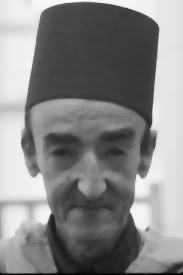

In [9]:
gray_blur = cv2.medianBlur(gray_img, 5)
cv2_imshow(gray_blur)

Edge detection using laplacian filter

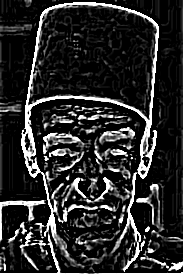

In [11]:
laplacian_edge = cv2.Laplacian(gray_blur, 0, ksize=5)
cv2_imshow(laplacian_edge)

Binary thresholding

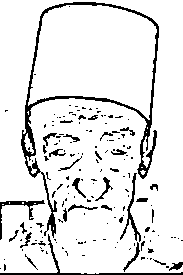

In [12]:
_, edge_img = cv2.threshold(laplacian_edge, 200, 255, cv2.THRESH_BINARY_INV)
cv2_imshow(edge_img)

## B. Generating a color painting and a cartoon

Image smoothing using bilateral filter

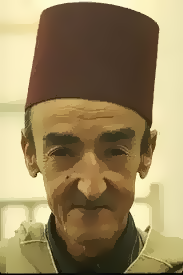

In [14]:
smoothed_img = cv2.bilateralFilter(org_img, 9, 15, 15)
for _ in range(5):
  smoothed_img = cv2.bilateralFilter(smoothed_img, 9, 15, 15)
cv2_imshow(smoothed_img)

## C. Overlaying the edge mask ”sketch” onto the bilateral filter ”painting”

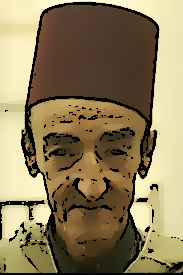

In [15]:
combined_img = np.zeros((org_img.shape))
for i in range(combined_img.shape[0]):
  for j in range(combined_img.shape[1]):
    if edge_img[i, j] == 0:
      combined_img[i, j] = 0
    else:
      combined_img[i, j] = smoothed_img[i, j]

cv2_imshow(combined_img)

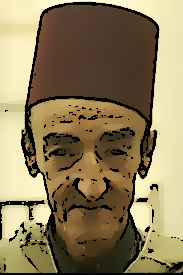

In [16]:
# alternative method
# using bitwise and to create final result
test_image = np.tile(edge_img[:, :, np.newaxis], (1, 1, 3)) & smoothed_img
cv2_imshow(test_image)

# Part II: Road Lane Detection Using Hough Transform



*   Download the image of the road 'test image' on the desk
*   Display the image of the road



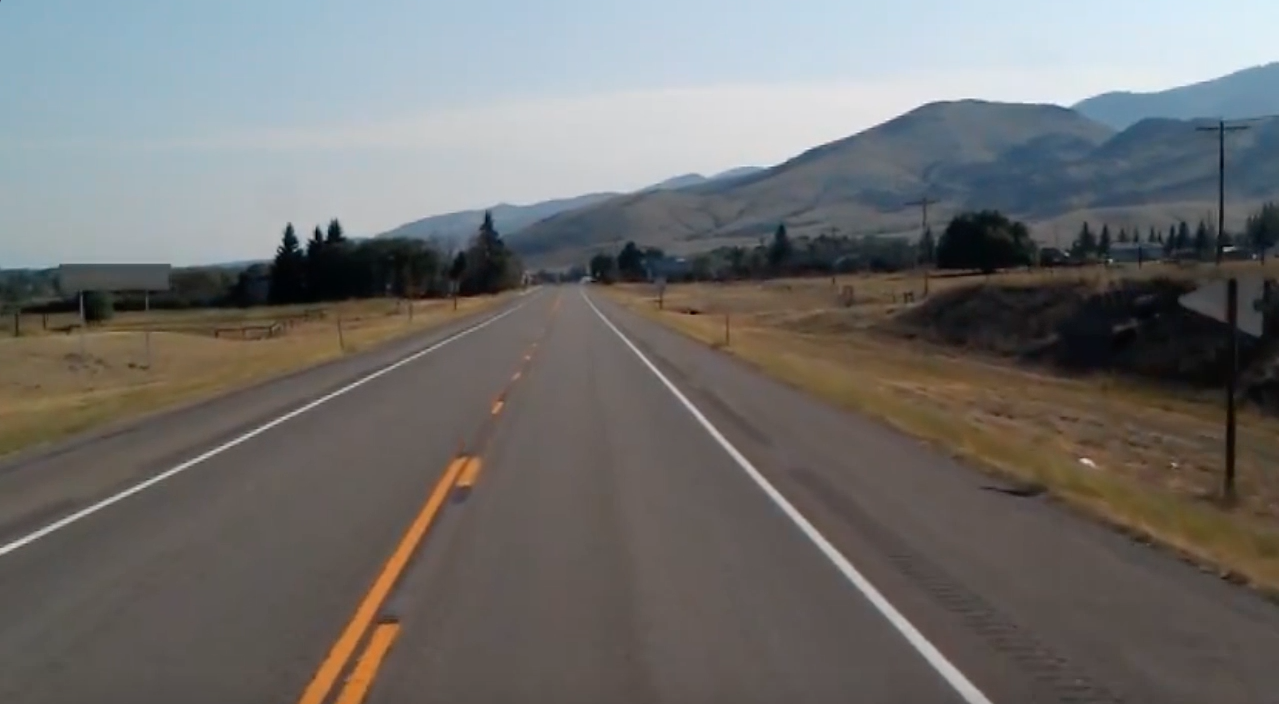

In [40]:
img_path = download_image('https://miro.medium.com/v2/resize:fit:1400/1*nTOydMnvcxnn_EcAdQUVOg.png', 'part2_image.jpg')
org_img = cv2.imread(img_path)
cv2_imshow(org_img)

**Non-Maximum Suppression**

  a post processing technique used to remove the duplicate detections and select the most relevant lines by choosing the local maximum and eliminating surrounding noisy predections


**Input**  the thresholded accumulator array that has proposal lines, the size of the sliding window

**Output** the filtered accumulator array

**Steps**

1. Perform padding on the accumulator array, so we can slide a window a long all pixels of the accumulator array and compare them with their neighbours.

2. for each pixel that represnet an anchor for the sliding window we check the following:

      * if the pixel value is larger than all neighbours, then store it in the resulted filtered accumulator array as a predicted line

      * if not then ignore it and doesn't store it as a predicted line in the filtered accumulator array

In [41]:
def non_max_suppression(prediction, kernel_size):

    height, width = prediction.shape[:2]
    result = np.zeros_like(prediction)

    prediction = np.pad(prediction, ((kernel_size // 2, kernel_size // 2), (kernel_size // 2, kernel_size // 2)), mode='constant', constant_values=0)

    for x in range(kernel_size // 2, height + kernel_size // 2):
        for y in range(kernel_size // 2, width + kernel_size // 2):
            if prediction[x, y] >= np.max(prediction[x - kernel_size // 2: x + kernel_size // 2 + 1, y - kernel_size // 2: y + kernel_size // 2 + 1]) and prediction[x, y] > 0:
                result[x - kernel_size // 2, y - kernel_size // 2] = 255
            else:
                result[x - kernel_size // 2, y - kernel_size // 2] = 0

    return result



*   Load the test image "Road Image" from the desk as Gray Scale image
*   Perform smoothing on the image by 5x5 median filter
*   Perform edge detection using Canny's Algorithm with threshold (150, 50)



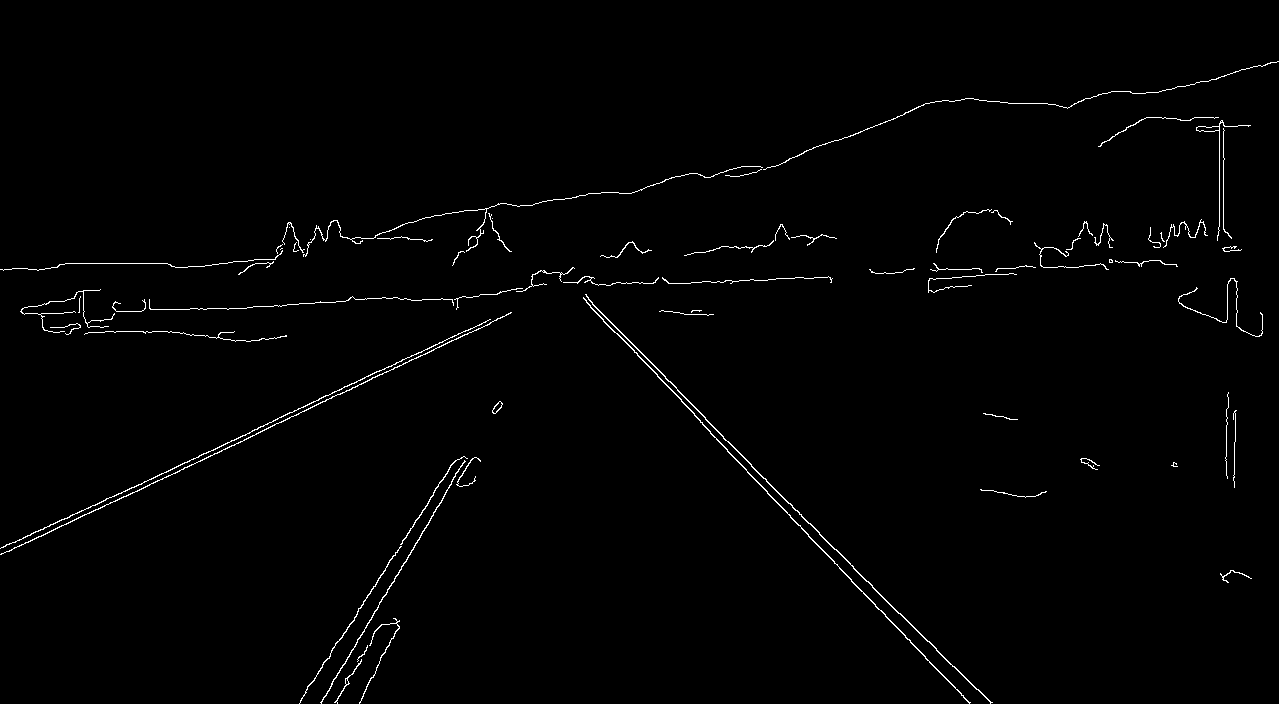

In [42]:
# Read the image of the road
image = cv2.imread(os.path.join(os.getcwd(), "part2_image.jpg"), 0)

# Apply the median filter with size 5 x 5
smoothed_image = cv2.medianBlur(image, 5)

# Detecting and thresholding using canny edge detector
edges = cv2.Canny(smoothed_image,50,150)

cv2_imshow(edges)



*   The edges resulted contains some un-necessaries related to the objects outside the road
*   We define the ROI by defining the coordinated of the vertieces of the polyogn

*  After that we mask the polygon with the edges to obtain only the edges belongs to lanes of the road



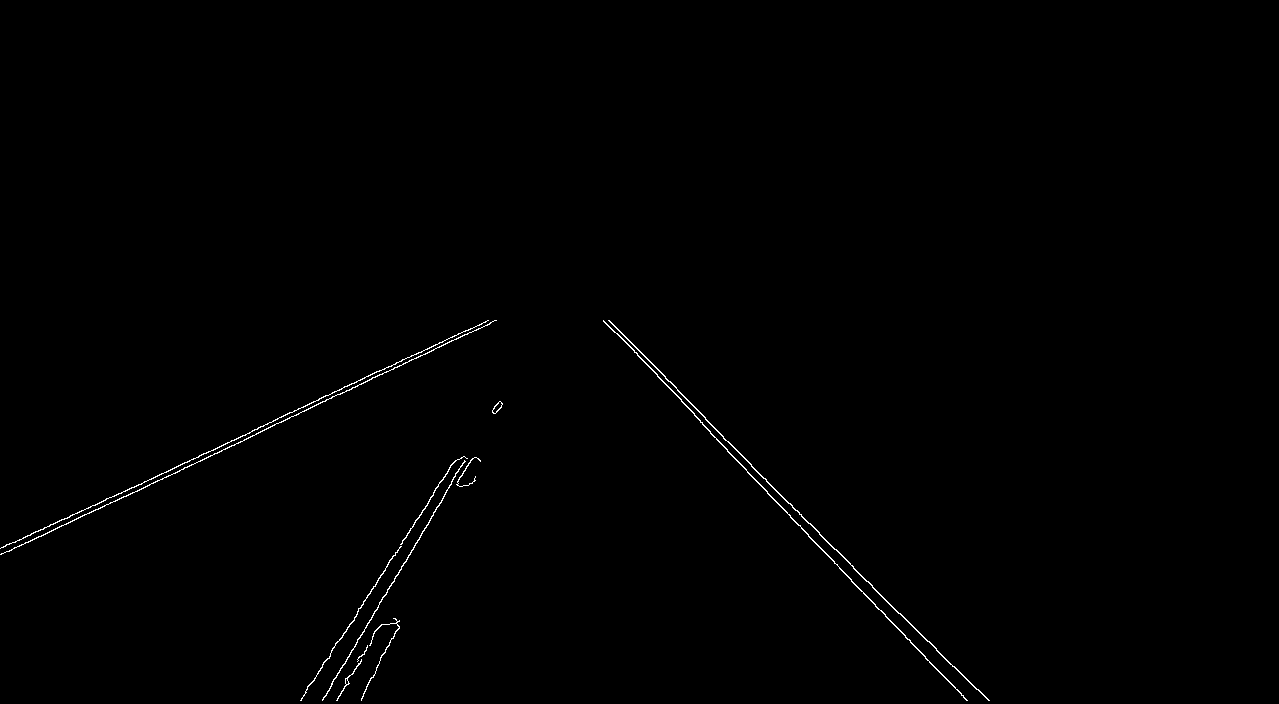

In [43]:
# Define the vertices of the polygon for the region of interest
vertices = np.array([[(0, 700), (0, 450), (420, 320), (800, 320), (1000, 700)]])

# Create a mask to apply to the edges image
mask = np.zeros_like(edges)
cv2.fillPoly(mask, vertices, 255)

# Apply the masking
masked_edges = cv2.bitwise_and(edges, mask)

cv2_imshow(masked_edges)

**In this part we apply the Hough Transform by accumulation on (rho, theta)**


Steps



1.   Construct the accumulator array with height = 2 * max rho, beacuse rho can be positive or negative and width = max theta.
2.   For all points the belongs to an edge, we compute rho for all theta that ranges from 0 to 180.
3.   After that we increase the votes at theta and the computed rho.
4.   After accumultationg on rho and theta we threshold the accumulator array at 220 because the points in accumulator array that has the maxmium votes represents the parameters of the actual lines on the image.
5.   Finally, we perofrm non max supression to remove duplicate detections.



In [44]:
height, width = masked_edges.shape[:2]

# Define the max possilbe row to equal the diagonal of the image
max_rho = math.ceil(np.linalg.norm((height, width)))
max_theta = 180

# Define the size of the acculmulator array to equal X [-max rho : max rho], Y [0 : 180] i.e (2 * max_rho, max_theta + 1)
acc = np.zeros((2 * max_rho, max_theta + 1))

# for each point that belong to edge compute rho when theta ranges from 0 to 180
for y, x in zip(*np.where(masked_edges == 255)):
    for theta in range(0,  max_theta + 1):

        rho = round(x * np.cos(np.deg2rad(theta)) + y * np.sin(np.deg2rad(theta)))

        # increase the votes in the accumulator array
        acc[max_rho - rho, theta] = acc[max_rho - rho, theta] + 1

# threshold the accumulator array at 220
thresh_acc = acc.copy()
thresh_acc[thresh_acc <= 220] = 0

# preform non max suppression to remove noisy lines
thresh_acc = non_max_suppression(thresh_acc, 7)

# convert the acculumator array indecies at the max votes to the actual rho and theta
lines = np.argwhere(thresh_acc == 255).astype(np.float64)
lines[:, 0] = max_rho - lines[:, 0]
lines[:, 1] = np.deg2rad(lines[:, 1])

In this part we plot the accumulator array

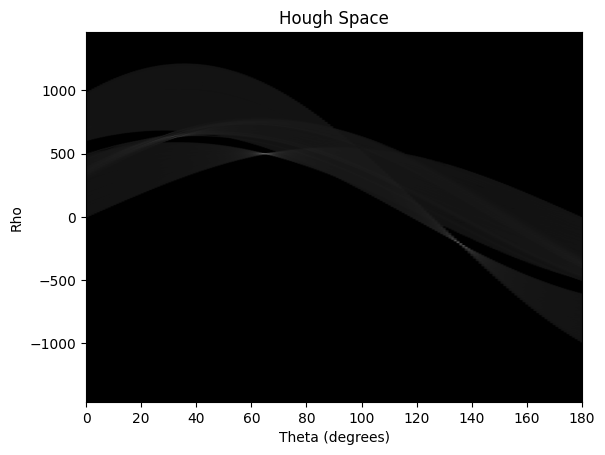

In [45]:
# increase the brightness
acc[acc > 0] += 25

# plot the accumulator array
plt.imshow(acc, cmap='gray', extent=[0, max_theta, -max_rho, max_rho],  aspect='auto')
plt.xlabel('Theta (degrees)')
plt.ylabel('Rho')
plt.title('Hough Space')
plt.show()

In this part we draw the lines obtained from Hough Transform

**steps**




1.   At first, we compute the coordinates of the intersection between the line resulted from the hough transform and the perpendicular line from the origin.

2.   Secondly, we extend the line in two directions to compute two points to be able to draw the line.

3.  Thirdly, we determine the ROI to clip lines drawn on the image



In [48]:
def draw_line(image, lines, thickness=2):
    img_with_lines = np.zeros_like(image)

    # Define the vertices of the polygon for the region of interest
    vertices = np.array([[(0, 700), (0, 500), (300, 400), (700, 350), (1000, 700)]])

    # Create a mask to apply to the drawn lines
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, vertices, 255)

    extension_length = max(img_with_lines.shape[0], img_with_lines.shape[1])
    for (rho, theta) in lines:
      a = np.cos(theta)
      b = np.sin(theta)

      x0 = a * rho
      y0 = b * rho

      x1 = int(x0 + extension_length * b)
      y1 = int(y0 + extension_length * -a)
      x2 = int(x0 - extension_length * b)
      y2 = int(y0 - extension_length * -a)

      cv2.line(img_with_lines, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=thickness)

    # Apply the masking
    masked_lines = cv2.bitwise_and(img_with_lines[:,:,1], mask[:,:,0])

    image_g = image[:,:,1]
    image_g[masked_lines > 0] = 255
    image[:,:,1] = image_g

    cv2_imshow(image)

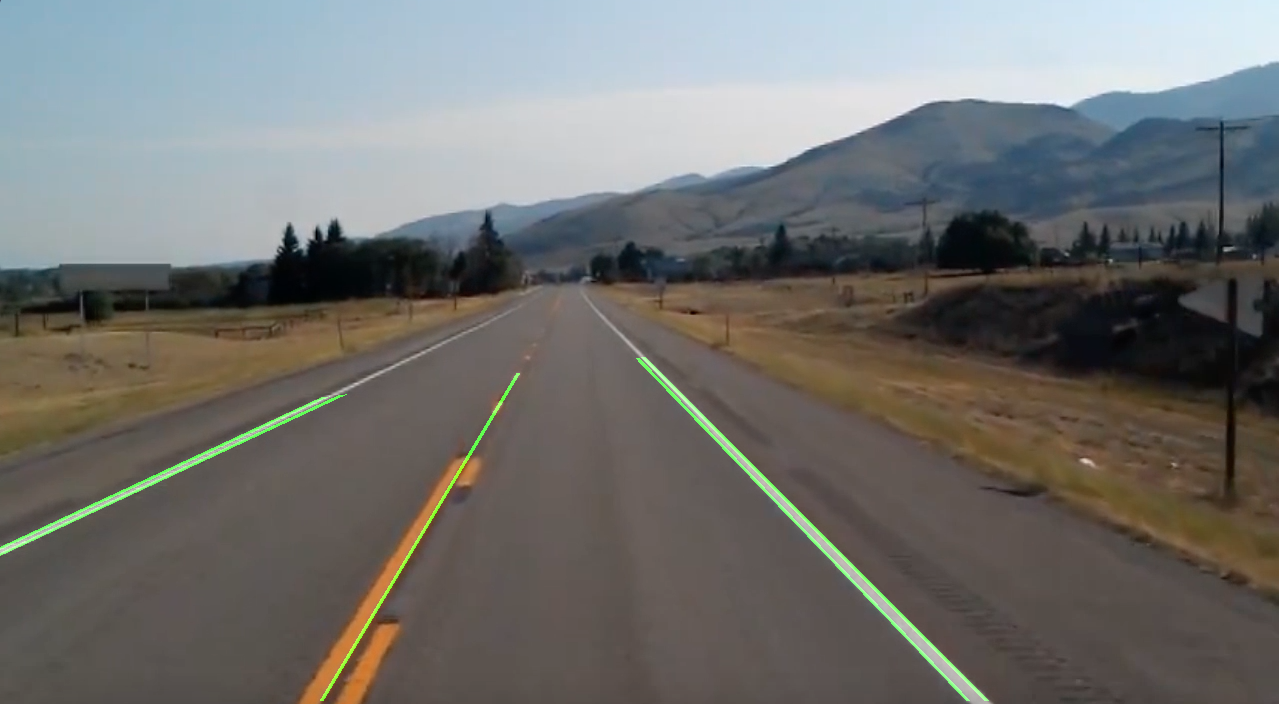

In [49]:
draw_line(cv2.imread(os.path.join(os.getcwd(), "part2_image.jpg")), lines)